In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimization
from scipy.optimize import curve_fit
import random
import statistics
from random import shuffle
from scipy import stats
from scipy.stats import binom
from scipy.optimize import minimize, rosen, rosen_der
from astropy.cosmology import WMAP9 as cosmo
import scipy.integrate as integrate
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

from scipy.integrate import solve_ivp
from astropy.modeling import models
from astropy import units as u
from scipy.constants import h,k,c
import warnings
warnings.filterwarnings("ignore")
from scipy import integrate, interpolate
import lmfit
import corner
from lmfit import Parameters, fit_report, minimize
from scipy.stats import norm
import scipy
from scipy.integrate import quad
import emcee
from sklearn.neighbors import KernelDensity
import sys
import os
from astropy.modeling import models
from astropy import units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15

from scipy.integrate import simps

import matplotlib.ticker as ticker

In [6]:
data = np.loadtxt('../LT_relation.txt')

z = data[:,0]
# m = data[:,1]

T = data [:,10]

s250 = data [:,1]
s250_err = data[:,2]

s350 = data [:,3]
s350_err = data[:,4]

s500 = data [:,5]
s500_err = data[:,6]

L_IR = data[:,7]
# L_IR = np.delete(L_IR, 171)

T_log = np.log10(data [:,10])
# T_log = np.delete(T_log, 171)

S_list = []
S_err_list = []
for i in range(len(s250)):
    
    S_list.append((s250[i],s350[i],s500[i]))
    
    S_err_list.append((s250_err[i],s350_err[i],s500_err[i]))
    

S_array = np.array(S_list)

S_err_array = np.array(S_err_list)




index_number = 86



spire_fluxes = (S_array[index_number])
spire_flux_errors = S_err_array[index_number]

# spire_fluxes = np.array([38.8, 56.8, 58.5 ]) 
# spire_flux_errors = np.array([12.4,7.0,5.3])


# actual source parameters
actual_z = z[index_number]
actual_T = T[index_number]



def convert_to_frequency(lam):
    # convert wavelength in um to frequency in Hz
    lam = lam * 1e-6
    return c / lam

def convert_to_wavelength(freq):
    # convert frequency in Hz to wavelength in um
    return 1e6 * c / freq

# ###########################################
# # Define constants

# # wavelength and frequency grids
wa = np.linspace(0.1, 500, 1000)
fa = convert_to_frequency(wa)

# # SPIRE band wavelengths and frequencies
SPIRE_wavelengths = [250, 350, 500]
SPIRE_frequencies = [convert_to_frequency(wavelength) for wavelength in SPIRE_wavelengths]

Beta = 1.5


In [5]:
wavelen_obs = np.array([250e-6,350e-6,500e-6])
    
freq_obs = (c/wavelen_obs)

beta = 1.5

wavelen_obs = np.array([250,350,500])*(10**-6)
    
freq_obs = (c/wavelen_obs)


c = scipy.constants.c
C = (2*scipy.constants.h)/(c*c)



In [14]:
def modified_blackbody_distribution(nu, T_obs, A):
    nu = nu
    

    f = (scipy.constants.h)/(scipy.constants.k)

    B_nu = (nu**3) / (np.exp(f*nu / T_obs) - 1)
    
    S_nu = A *C * (nu**Beta) * B_nu  
    
    return S_nu



def deredshifted_modified_blackbody_distribution(nu, T, A, z):
    return modified_blackbody_distribution(nu / (1 + z), T, A) / (1 + z)

# Vectorize relevant functions
vector_modified_blackbody_distribution = np.vectorize(modified_blackbody_distribution)
vector_deredshifted_modified_blackbody_distribution = np.vectorize(deredshifted_modified_blackbody_distribution)

def compute_lum_dist(z_input):
    """
    Return the luminosity distance in SI units given redshift
    """
    return Distance(z=z_input, cosmology=Planck15).si.value

vector_compute_lum_dist = np.vectorize(compute_lum_dist)


best_fit_poly = [0.13930927, 5.9594352]


x_scatter = np.random.normal(0, 0.5, 1)


f = lambda e: (10**(np.polyval(best_fit_poly, e)+ x_scatter )) * 3.828e26 


# compute derivative of L-T function
der_poly = np.polyder(best_fit_poly)
# df_de = lambda e: gamma*(10**alpha)*(e**(gamma-1))

df_de = lambda e: np.log(10) * np.polyval(der_poly, e) * f(e)


# Set up function to interpolate derivative of luminosity function
start = 0.01
end = 7.5
steps = 3000

z_grid, dz = np.linspace(start, end, steps, retstep=True)

DL = vector_compute_lum_dist(z_grid)
dDL_dz = np.gradient(DL, dz)
dDL_map = interpolate.interp1d(z_grid, dDL_dz)


In [15]:
########################### Define transformation of variables functions ###########################

################## Define coordinate functions ##################

def g(z, e, S):
    # returns A as a function of z, e, S(z, e)
    return f(e) / (S * 4 * np.pi * compute_lum_dist(z)**2)

def h(z, e):
    # returns T_obs as a function of z, e
    return e / (1 + z)

################## Define integration functions ##################

# Set integration constant params
upper_bound_b = convert_to_frequency(8)
lower_bound_c = convert_to_frequency(1000)

def integrate_S(z, e):
    # Compute source frame flux with A = 1
    fitted_func = lambda nu: vector_deredshifted_modified_blackbody_distribution(nu, T = e, A=1, z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR 

def integrate_dS_dz(z, e):
    # Compute dS_dz
    fitted_func = lambda nu: dS_dz(nu, T = e , z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR


def dS_dz(nu, T, z):
    Beta = 1.5
    nu = nu 

    f = (scipy.constants.h)/(scipy.constants.k)

    return - C*(4 + Beta) * nu**(3 + Beta) * (1/(1 + z)**(5 + Beta))  / (np.exp(f*nu / T) - 1) 



def integrate_dS_de(z, e):
    # Compute dS_de
    fitted_func = lambda nu: dS_de(nu, T_e = e , z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR 




def dS_de(nu, T_e, z):
    Beta = 1.5
    nu = nu 

    f = (scipy.constants.h)/(scipy.constants.k)

    dS = nu**(3 + Beta) * (1/(1 + z)**(4 + Beta)) * (f*nu/T_e**2) * np.exp(f*nu / T_e)  / (np.exp(f*nu/T_e) - 1)**2
    
    return dS 



# ################## Define derivative functions ##################

# ######### dg_dz and helpers #########

def dg_dz(z, e, S):
    g1, dg1_dz = get_g1z_vals(z, e, S)
    g2, dg2_dz = get_g2z_vals(z, e, S)
    return dg1_dz*g2 + g1*dg2_dz


def get_g1z_vals(z, e, S):
    g1 = 1 / S

    integrated_dS_dz = np.vectorize(integrate_dS_dz)(z, e)
    dg1_dz = (- 1 / S**2) * integrated_dS_dz
    return g1, dg1_dz

def get_g2z_vals(z, e, S):
    g2 = f(e) / (4 * np.pi * compute_lum_dist(z)**2)
    dg2_dz = - 2 * f(e) / (4 * np.pi * compute_lum_dist(z)**3) * dDL_map(z)
    return g2, dg2_dz


# ######### dg_de and helpers #########

def dg_de(z, e, S):
    g1, dg1_de = get_g1e_vals(z, e, S)
    g2, dg2_de = get_g2e_vals(z, e)
    return dg1_de*g2 + g1*dg2_de

def get_g1e_vals(z, e, S):
    g1 = 1 / S
    dg1_de = - 1 / S**2 * np.vectorize(integrate_dS_de)(z, e)
    return g1, dg1_de

def get_g2e_vals(z, e):
    g2 = f(e) / (4 * np.pi * compute_lum_dist(z)**2)
    dg2_de = df_de(e) / (4 * np.pi * compute_lum_dist(z)**2)
    return g2, dg2_de


# ######### dh and helpers #########

def dh_dz(z, e):
    return - e / (1 + z)**2

def dh_de(z, e):
    
    
    return 1 / (1 + z)


# ######### pdf functions and helpers #########
def get_coords(z, e):
    # returns output coordinates from z and T_obs
    S = integrate_S(z, e)
    return np.array([h(z, e), g(z, e, S)])

def jacobian(z, e, S):
    # returns the jacobian from coordinates
    return np.abs(dg_dz(z, e, S)*dh_de(z, e) - dg_de(z, e, S)*dh_dz(z, e))

# Grid resolution
N = 80
M = 80
# Number of steps taken in MCMC
MCMC_steps = 1000

In [49]:
h

<function __main__.h(z, e)>

In [16]:
# Define search grid
z_grid = np.linspace(0.1, 4.5, N)
e_grid = np.linspace(5, 50, M)

# Define Mesh
zz, ee = np.meshgrid(z_grid, e_grid)

# Define corresponding mesh of indices
z_index, e_index = np.meshgrid(range(len(z_grid)), range(len(e_grid)))

# print("Initializing parameters")
# time0 = time.time()


S_grid = np.vectorize(integrate_S)(zz, ee)

hh, gg = np.vectorize(h)(zz, ee), np.vectorize(g)(zz, ee, S_grid)

# Compute relevant values at each point
print("Initializing parameters")
time0 = time.time()

# evaluate flux at each point in mesh
S_grid = np.vectorize(integrate_S)(zz, ee)
print("finished flux grid")

# get change of variables points at each location in mesh
hh, gg = np.vectorize(h)(zz, ee), np.vectorize(g)(zz, ee, S_grid)
print("finished output coordinate grid")

# evaluate jacobian at each point in mesh
jacob = np.vectorize(jacobian)(zz, ee, S_grid)
print("finished jacobian")

# time1 = time.time()

# print("Initialization took: ", time1 - time0)

Initializing parameters
finished flux grid
finished output coordinate grid
finished jacobian


# ######

In [29]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde

def plot_3_flux(index_number):
    spire_fluxes, spire_flux_errors = S_array[index_number], S_err_array[index_number]
    actual_z, actual_T = z[index_number], T[index_number]

    # Set initial fit parameters
    p = lmfit.Parameters()
    p.add_many(('T0', 10), ('A0', 1))

    # Define residual function
    def residual(p):
        v = p.valuesdict()
        return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

    # Obtain initial fit using minimizers
    mi = lmfit.minimize(residual, p, method='nelder')

    # Show best fit model
    T_obs, A = mi.params['T0'].value, mi.params['A0'].value
    best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

    # Create subplots for side-by-side display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Best fitting model vs. data
    ax1.loglog()
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    ax1.set_ylabel('Flux density [mJ]', fontsize=18)
    ax1.plot(wa, best_fit, label='Best fitting model')
    ax1.errorbar(SPIRE_wavelengths, spire_fluxes, yerr=spire_flux_errors)
    ax1.set_xlim(5e1, 6e2)
    ax1.set_ylim(1e-1, 2e1)

    # Set xticks for ax1
    locs = np.append(ax1.xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    ax1.xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    ax1.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax1.tick_params(axis='both', which='major', labelsize=16)

    # Run MCMC chain using initial fit
    res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                         params=mi.params, is_weighted=True, progress=False)

    # Get MCMC outputs
    Ts = np.array(res.flatchain['T0'])
    As = np.array(res.flatchain['A0'])

    # Define normalized pdf over fit params
    values = np.vstack([Ts, As])
    kde_kernel = gaussian_kde(values)

    # Plot 2: Gaussian kernel with actual source parameters
    mapped_point = get_coords(actual_z, mi.params['T0'].value * (1 + actual_z))
    print("Optimal: ", mapped_point)

    N = 100
    X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde_kernel(positions).T, X.shape)
    Z = Z / np.sum(Z)

    ax2.contour(X, Y, Z, 20)
    ax2.set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
    ax2.set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim([Ts.min(), Ts.max()])
    ax2.set_ylim([As.min(), As.max()])

    # Add color bar
    cbar = fig.colorbar(ax2.contourf(X, Y, Z, 20, cmap='RdGy'), ax=ax2)
    cbar.set_label('Probability density', fontsize=18, labelpad=15)

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Print fit report
    lmfit.printfuncs.report_fit(mi.params, min_correl=0.0)
#     print('--------------------------------------------')
#     print('Theoretical T_obs = ', actual_T / (1 + actual_z))



######### define array access functions using kde from fit #########

    def get_pdf_s_t(a, t):
        # returns pdf sampled using kde at values a and t in fit param space (observer frame parameters)
        return kde_kernel.pdf(np.array([[t, a]]).T)[0]

    def get_p_z_e(z_i, e_i):
        # computes pdf value in fit space sampled from meshgrid indices z_i and e_i
        return get_pdf_s_t(a=gg[z_i, e_i], t=hh[z_i, e_i])

    # define function for vectorizing computation of pdf
    pdf_z_e = np.vectorize(get_p_z_e)

    # compute pdf over emission frame meshgrid
    p_z_e = np.array(pdf_z_e(z_i=z_index, e_i=e_index))

#     p_z_e = p_z_e/np.sum(p_z_e)


    plt.contour(zz, ee, p_z_e, 20, cmap='RdGy', label = 'tet4t4')

    plt.xlabel(r'$\mathit{z}$', fontsize=18)
    plt.ylabel(r'$\mathit{T}_{\mathrm{em}}$', fontsize=18, rotation=0, labelpad=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # plt.title('pdf over T_em and z after jacobian')
    # cbar = plt.colorbar()
    cbar.set_label('Probability density', fontsize=18, labelpad=20)

    plt.legend()
    plt.show()
    
    # multiply by jacobian
    p_z_e = p_z_e * jacob

    # marginalize over e
    p_z = np.array([simps(p, e_grid) for p in p_z_e.T])

    p_z = p_z/np.sum(p_z)

    # display marginalized pdf results after multiplication by jacobian
    # plt.figure(figsize=(8, 6))
    plt.plot(z_grid, p_z)
    plt.axvline(x=z[index_number], label='True redshift', linestyle = 'dashed')
    # plt.title('pdf over z after jacobian')
    # plt.tick_params(axis='y', which='both', labelrotation=90)



    plt.xlabel(r'$\mathit{z}$', fontsize=18)
    plt.ylabel(r'$p(z)$', fontsize=18, rotation=90)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

    plt.show()



The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [81.09024751 75.45695997]
Optimal:  [16.75945113606906 array([2.89993518e-34])]


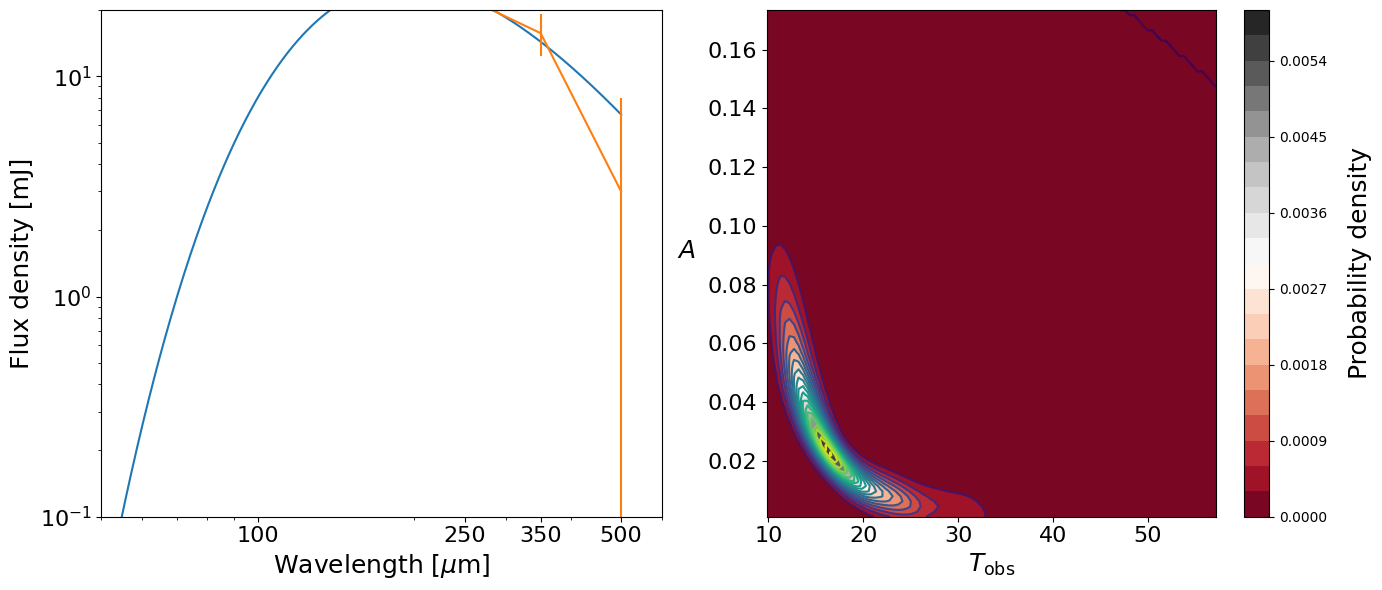

[[Variables]]
    T0:  16.7594511 (init = 10)
    A0:  0.02075309 (init = 1)


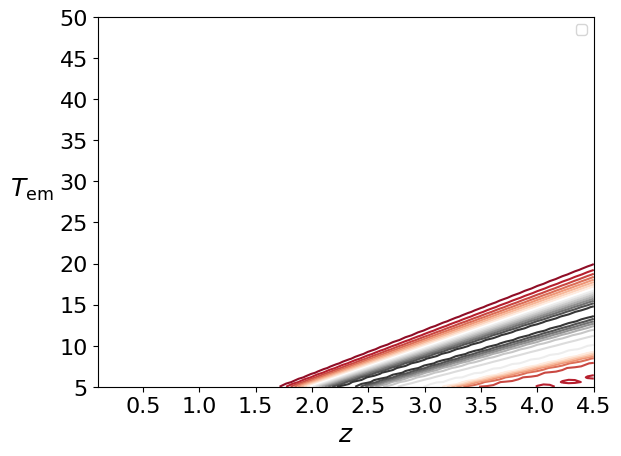

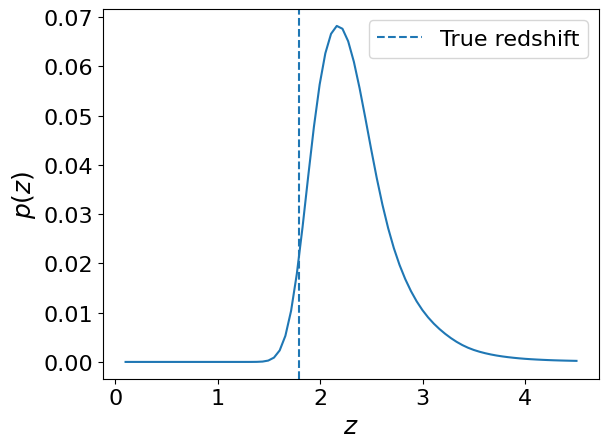

In [30]:
plot_3_flux(167)

In [105]:
def plot_3_flux(index1, index2):
    # Get data for both galaxies
    spire_fluxes_1, spire_flux_errors_1 = S_array[index1], S_err_array[index1]
    actual_z_1, actual_T_1 = z[index1], T[index1]

    spire_fluxes_2, spire_flux_errors_2 = S_array[index2], S_err_array[index2]
    actual_z_2, actual_T_2 = z[index2], T[index2]

    # Initial fit parameters for both galaxies
    def get_fit_params(spire_fluxes, spire_flux_errors):
        p = lmfit.Parameters()
        p.add_many(('T0', 10), ('A0', 1))

        def residual(p):
            v = p.valuesdict()
            return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

        mi = lmfit.minimize(residual, p, method='nelder')
        return mi, residual

    # Fit results for Galaxy 1
    mi_1, residual_1 = get_fit_params(spire_fluxes_1, spire_flux_errors_1)
    T_obs_1, A_1 = mi_1.params['T0'].value, mi_1.params['A0'].value
    best_fit_1 = vector_modified_blackbody_distribution(fa, T_obs_1, A_1)

    # Fit results for Galaxy 2
    mi_2, residual_2 = get_fit_params(spire_fluxes_2, spire_flux_errors_2)
    T_obs_2, A_2 = mi_2.params['T0'].value, mi_2.params['A0'].value
    best_fit_2 = vector_modified_blackbody_distribution(fa, T_obs_2, A_2)

    # Subplots for side-by-side display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Best fitting model for both galaxies, plotted independently
    ax1.loglog()
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    ax1.set_ylabel('Flux density [mJ]', fontsize=18)

    # Plot for Galaxy 1
    ax1.plot(wa, best_fit_1, label=f'Galaxy {index1} Best Fit', color='blue')
    ax1.errorbar(SPIRE_wavelengths, spire_fluxes_1, yerr=spire_flux_errors_1, label=f'Galaxy {index1} Data', color='blue')

    # Plot for Galaxy 2
    ax1.plot(wa, best_fit_2, label=f'Galaxy {index2} Best Fit', linestyle='--', color='red')
    ax1.errorbar(SPIRE_wavelengths, spire_fluxes_2, yerr=spire_flux_errors_2, label=f'Galaxy {index2} Data', fmt='--', color='red')

    ax1.legend()

    # Dynamically adjust x and y limits based on the range of data
    ax1.set_xlim([50, 600])  # Adjust x-axis to focus on relevant wavelengths
    ax1.set_ylim([1, 100])   # Adjust y-axis to focus on the flux density range

    # Set xticks for ax1
    locs = np.append(ax1.xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    ax1.xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    ax1.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax1.tick_params(axis='both', which='major', labelsize=16)

    # Run MCMC for both galaxies
    def run_mcmc(residual, mi):
        res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                             params=mi.params, is_weighted=True, progress=True)
        Ts = np.array(res.flatchain['T0'])
        As = np.array(res.flatchain['A0'])
        return Ts, As, res

    # MCMC results for both galaxies
    Ts_1, As_1, _ = run_mcmc(residual_1, mi_1)
    Ts_2, As_2, _ = run_mcmc(residual_2, mi_2)

    # Define Gaussian KDE and plot for both galaxies
    def plot_kde(ax, Ts, As, galaxy_index, color):
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        N = 100
        X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kde_kernel(positions).T, X.shape)
        Z = Z / np.sum(Z)

        # Only contour lines, no background fill
        contour = ax.contour(X, Y, Z, 20, colors=color, label=f'Galaxy {galaxy_index}')
        
        ax.set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
        ax.set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=16)

        return contour

    # Plot 2: Gaussian kernel for both galaxies, plotted independently
    contour1 = plot_kde(ax2, Ts_1, As_1, index1, color='blue')
    contour2 = plot_kde(ax2, Ts_2, As_2, index2, color='red')
    
    # Dynamically adjust x and y limits based on the MCMC results
    ax2.set_xlim([0, 20])    # Adjust x-axis to focus on relevant T_obs range
    ax2.set_ylim([0, 0.7])   # Adjust y-axis to focus on relevant A range

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Print fit reports for both galaxies
    lmfit.printfuncs.report_fit(mi_1.params, min_correl=0.0)
    print('--------------------------------------------')
    print(f'Galaxy {index1} Theoretical T_obs = ', actual_T_1 / (1 + actual_z_1))

    lmfit.printfuncs.report_fit(mi_2.params, min_correl=0.0)
    print('--------------------------------------------')
    print(f'Galaxy {index2} Theoretical T_obs = ', actual_T_2 / (1 + actual_z_2))


100%|██████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.01it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [65.90308702 60.90336001]


100%|██████████████████████████████████████████| 1000/1000 [00:04<00:00, 224.90it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [61.46425686 58.03267911]


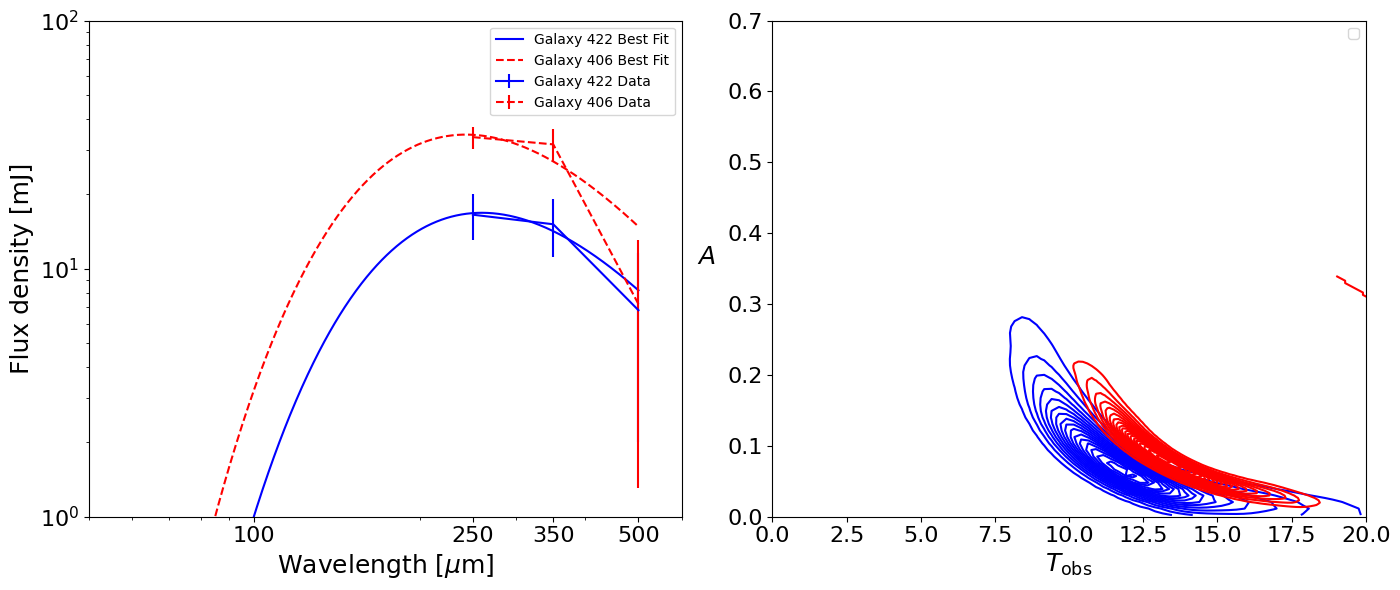

[[Variables]]
    T0:  12.4700904 (init = 10)
    A0:  0.05016292 (init = 1)
--------------------------------------------
Galaxy 422 Theoretical T_obs =  12.457586039747941
[[Variables]]
    T0:  13.3308581 (init = 10)
    A0:  0.07675299 (init = 1)
--------------------------------------------
Galaxy 406 Theoretical T_obs =  12.402669632925473


In [106]:
plot_3_flux(422,406)

100%|██████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.45it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [67.57020953 64.86080598]


100%|██████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.32it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [53.25353273 52.71759616]


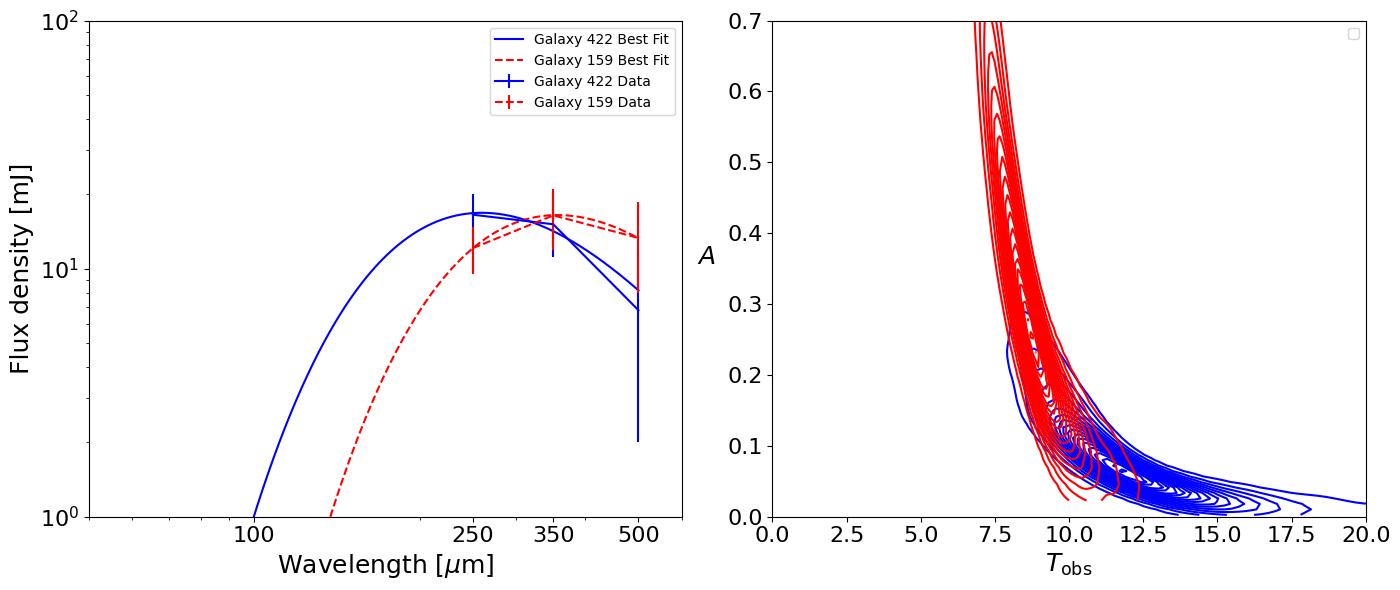

[[Variables]]
    T0:  12.4700904 (init = 10)
    A0:  0.05016292 (init = 1)
--------------------------------------------
Galaxy 422 Theoretical T_obs =  12.457586039747941
[[Variables]]
    T0:  9.07586433 (init = 10)
    A0:  0.20515956 (init = 1)
--------------------------------------------
Galaxy 159 Theoretical T_obs =  8.033826638477802


In [109]:
plot_3_flux(422,159)

In [46]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.integrate import simps

# Define global grids (you may need to adjust these values according to your dataset)
T_em_grid = np.linspace(5, 50, 100)  # Emission temperature grid, adjust as needed
z_grid = np.linspace(0, 3, 100)      # Redshift grid, adjust as needed
jacob = np.ones((len(z_grid), len(T_em_grid)))  # Dummy Jacobian for now, replace with actual Jacobian if needed

# Function to plot results for two galaxies in a 2x2 panel
def plot_flux_for_two_galaxies(index1, index2):
    def plot_best_fit(ax, spire_fluxes1, spire_flux_errors1, best_fit1, spire_fluxes2, spire_flux_errors2, best_fit2):
        ax.loglog()
        ax.set_xlabel('Wavelength [$\mu$m]', fontsize=18)
        ax.set_ylabel('Flux density [mJ]', fontsize=18)
        
        
        # Plot best fit and scatter for Galaxy 1
        ax.plot(wa, best_fit1, label=f'Galaxy {index1} Best Fit', color='blue')
        ax.errorbar(SPIRE_wavelengths, spire_fluxes1, yerr=spire_flux_errors1, label=f'Galaxy {index1} Data', fmt='o', color='blue')

        # Plot best fit and scatter for Galaxy 2
        ax.plot(wa, best_fit2, label=f'Galaxy {index2} Best Fit', linestyle='--', color='red')
        ax.errorbar(SPIRE_wavelengths, spire_fluxes2, yerr=spire_flux_errors2, label=f'Galaxy {index2} Data', fmt='--', color='red')

        # Set axis limits
        ax.set_xlim([50, 600])
        ax.set_ylim([1, 100])

        # Format x-ticks for better readability
        locs = np.append(ax.xaxis.get_major_locator().tick_values(50, 600), [250, 350, 500])
        ax.xaxis.set_major_locator(ticker.FixedLocator(locs))
        labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(fontsize=14)

    def plot_kde_contour(ax, Ts1, As1, Ts2, As2):
        # KDE for Galaxy 1
        values1 = np.vstack([Ts1, As1])
        kde_kernel1 = gaussian_kde(values1)
        
        # KDE for Galaxy 2
        values2 = np.vstack([Ts2, As2])
        kde_kernel2 = gaussian_kde(values2)

        N = 100
        X, Y = np.meshgrid(np.linspace(min(Ts1.min(), Ts2.min()), max(Ts1.max(), Ts2.max()), N),
                           np.linspace(min(As1.min(), As2.min()), max(As1.max(), As2.max()), N))
        positions = np.vstack([X.ravel(), Y.ravel()])

        # Contour for Galaxy 1
        Z1 = np.reshape(kde_kernel1(positions).T, X.shape)
        Z1 = Z1 / np.sum(Z1)

        # Contour for Galaxy 2
        Z2 = np.reshape(kde_kernel2(positions).T, X.shape)
        Z2 = Z2 / np.sum(Z2)

        # Plot contours for both galaxies
        ax.contour(X, Y, Z1, 20, cmap='Blues', label=f'Galaxy {index1}')
        ax.contour(X, Y, Z2, 20, cmap='Reds', label=f'Galaxy {index2}')
        ax.set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
        ax.set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=16)

    def plot_contour_zz_ee(ax, zz, ee, p_z_e1, p_z_e2):
        ax.contour(zz, ee, p_z_e1, 20, cmap='Blues', label=f'Galaxy {index1}')
        ax.contour(zz, ee, p_z_e2, 20, cmap='Reds', label=f'Galaxy {index2}')
        ax.set_xlabel(r'$\mathit{z}$', fontsize=18)
        ax.set_ylabel(r'$\mathit{T}_{\mathrm{em}}$', fontsize=18, rotation=0, labelpad=20)
        ax.tick_params(axis='both', which='major', labelsize=16)

    def plot_p_z(ax, z_grid, p_z1, p_z2):
        ax.plot(z_grid, p_z1, label=f'Galaxy {index1} $p(z)$', color='blue')
        ax.plot(z_grid, p_z2, label=f'Galaxy {index2} $p(z)$', color='red')
        ax.axvline(x=z[index1], color='blue', linestyle='dashed', label=f'Galaxy {index1} True $z$')
        ax.axvline(x=z[index2], color='red', linestyle='dashed', label=f'Galaxy {index2} True $z$')
        ax.set_xlabel(r'$\mathit{z}$', fontsize=18)
        ax.set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(fontsize=14)

    # Fit and plot best-fitting model for both galaxies
    def get_fit_results(index):
        spire_fluxes, spire_flux_errors = S_array[index], S_err_array[index]
        actual_z, actual_T = z[index], T[index]

        p = lmfit.Parameters()
        p.add_many(('T0', 10), ('A0', 1))

        def residual(p):
            v = p.valuesdict()
            return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

        # Initial minimization
        mi = lmfit.minimize(residual, p, method='nelder')

        # Best fit values
        T_obs = mi.params['T0'].value
        A = mi.params['A0'].value
        best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

        # MCMC minimization
        res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                             params=mi.params, is_weighted=True, progress=False)

        Ts = np.array(res.flatchain['T0'])
        As = np.array(res.flatchain['A0'])

        # Define KDE
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        # Create grid for z vs T_em contour plot
        zz, ee = np.meshgrid(z_grid, T_em_grid)
        p_z_e = np.array([[kde_kernel([zz_val, ee_val])[0] for zz_val, ee_val in zip(z_row, ee_row)] for z_row, ee_row in zip(zz, ee)])
        
        # Multiply by Jacobian
        p_z_e *= jacob

        # Marginalize over T_em
        p_z = np.array([simps(p, T_em_grid) for p in p_z_e.T])
        p_z /= np.sum(p_z)

        return best_fit, spire_fluxes, spire_flux_errors, Ts, As, zz, ee, p_z_e, p_z

    # Get fit results for both galaxies
    (best_fit1, spire_fluxes1, spire_flux_errors1, Ts1, As1, zz1, ee1, p_z_e1, p_z1) = get_fit_results(index1)
    (best_fit2, spire_fluxes2, spire_flux_errors2, Ts2, As2, zz2, ee2, p_z_e2, p_z2) = get_fit_results(index2)

    # Set up 2x2 figure layout
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot best-fitting model and scatter points for flux data (Top Left)
    plot_best_fit(axs[0, 0], spire_fluxes1, spire_flux_errors1, best_fit1, spire_fluxes2, spire_flux_errors2, best_fit2)

    # Plot KDE contours for T_obs and A (Top Right)
    plot_kde_contour(axs[0, 1], Ts1, As1, Ts2, As2)

    # Plot contour of redshift and emission temperature (Bottom Right)
    plot_contour_zz_ee(axs[1, 1], zz1, ee1, p_z_e1, p_z_e2)

    # Plot PDF of redshift (Bottom Left)
    plot_p_z(axs[1, 0], z_grid, p_z1, p_z2)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Call the function for two galaxies with their indices



The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [66.01199953 60.45835138]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [63.3920287 60.0960469]


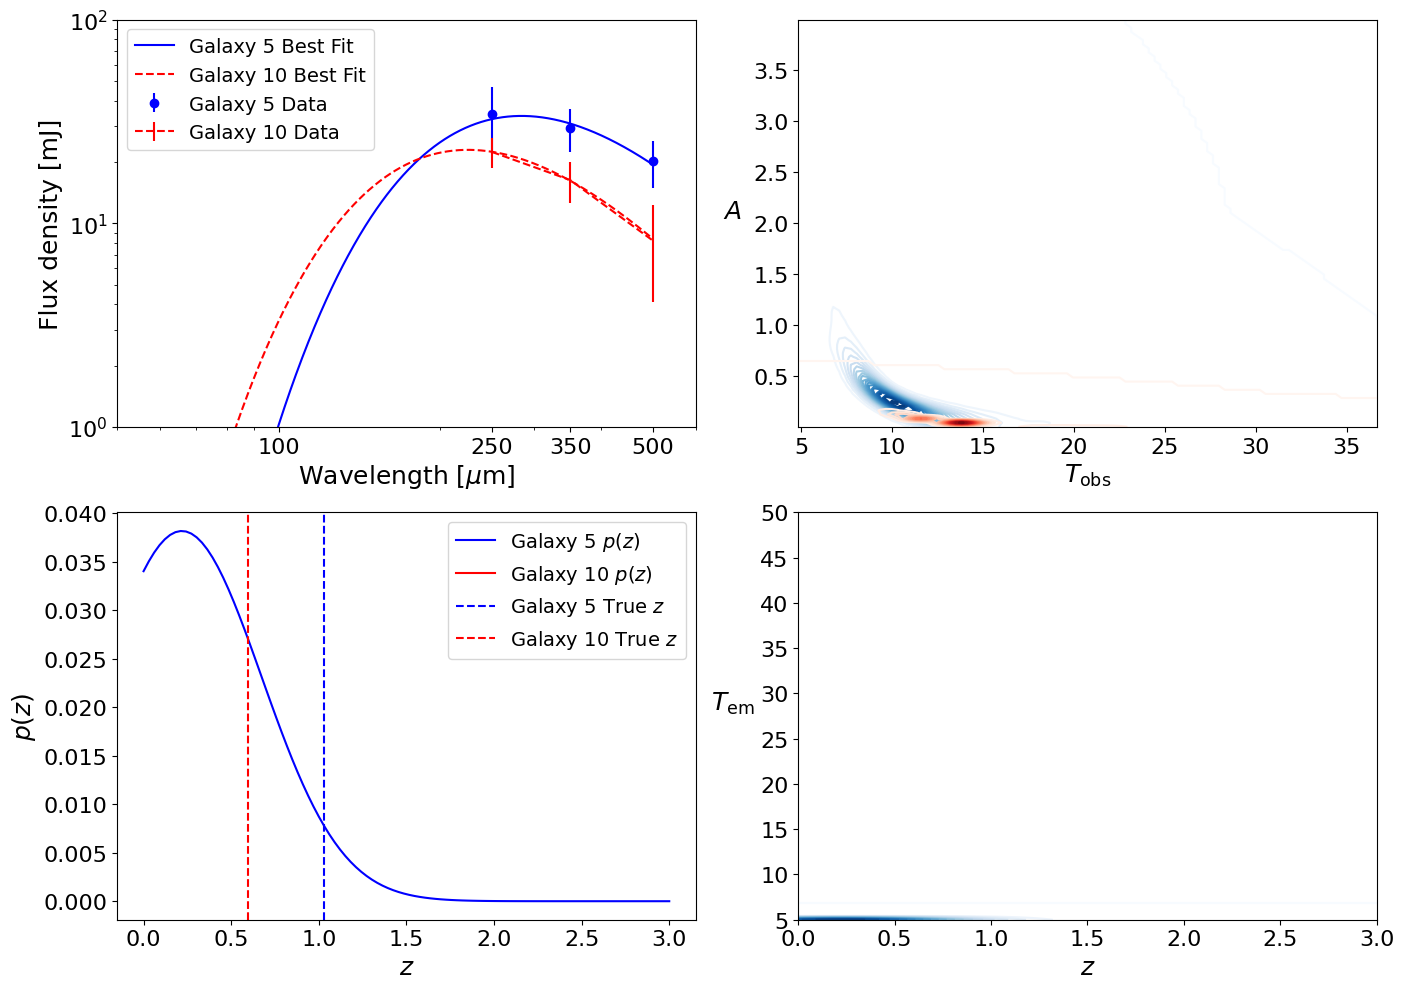

In [50]:
plot_flux_for_two_galaxies(index1=5, index2=10)



In [56]:
# plot_flux_for_two_galaxies(index1=47, index2=29)

In [52]:
# index that worked for both: 85j, 86p, 

# only josh: 87, 88, 89, 90

#only pouya: 

# bad example :29

# 39 good bad

# anoher good 47